In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
# jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as gp

import matplotlib.pyplot as plt
import cmasher as cmr
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

rng = jr.key(137)

In [3]:
n_points = 100_000
rng, k1 = jr.split(rng, 2)
points = jr.normal(k1, (n_points, 2))
graph = gp.build_graph(points, n0=1000, k=10, cuda=True)
cov_func = gp.MaternCovariance(p=0)
cov_bins = gp.make_cov_bins(r_min=1e-4, r_max=10, n_bins=1000)
covariance = (cov_bins, cov_func)

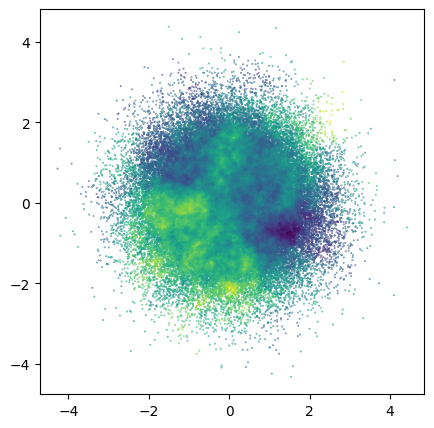

In [5]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, (n_points,))
values = gp.generate(graph, covariance, xi, cuda=True)

plt.figure(figsize=(5, 5))
plt.scatter(*points.T, c=values, s=.1)
plt.gca().set(aspect='equal')
plt.show()